In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/portrait-smiling-middle-aged-african-260nw-2088822202.jpg
/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/A142xwh4GVL._AC_UF8941000_QL80_.jpg
/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpg
/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/people-strategy_1200x700.jpg
/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/360_F_606797008_rGPPk6bFWDQydnX7g7w1w9dVVZ4mD22J.jpg
/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/71afyFfZx0L._AC_UF8941000_QL80_.jpg
/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/180222162827-the-kiss-story-top-card-image.jpg
/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/COLORFUL-NIGHT.jpg
/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/thumb-duiker-animal.jpg
/kaggle/input/ai-generated-image

In [2]:
import numpy as np
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import (InputLayer, Conv2D,MaxPool2D, GlobalAveragePooling2D, 
                          Dense, BatchNormalization, Dropout, ELU, UpSampling2D)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Nadam
from keras.layers import Input, Multiply, UpSampling2D
from keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

2025-06-30 16:42:37.096684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751301757.308487      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751301757.373278      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
ai_dataset=keras.utils.image_dataset_from_directory(
    "/kaggle/input/ai-generated-images-vs-real-images/AiArtData",
    image_size=(224,224),
    batch_size=32,
    label_mode='int'
)

real_dataset=keras.utils.image_dataset_from_directory(
    "/kaggle/input/ai-generated-images-vs-real-images/RealArt",
    image_size=(224,224),
    batch_size=32,
    label_mode='int'
)

Found 536 files belonging to 1 classes.


I0000 00:00:1751301770.395101      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751301770.395787      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 435 files belonging to 1 classes.


In [4]:
normalization_layer=tf.keras.layers.Rescaling(1./255)

In [5]:
#real images label ->0
#AI images label ->1
normalize_ai_dataset=ai_dataset.map(lambda x, y: (normalization_layer(x), tf.ones_like(y)))
normalize_real_dataset=real_dataset.map(lambda x, y: (normalization_layer(x), tf.zeros_like(y)))

In [6]:
final_dataset=normalize_ai_dataset.concatenate(normalize_real_dataset)
final_dataset=final_dataset.shuffle(buffer_size=1000)

In [7]:
image_list=[]
label_list=[]

for images, labels in final_dataset:
    for image, label in zip(images,labels):
        image_list.append(image.numpy())
        label_list.append(label.numpy())

image_array=np.array(image_list)
label_array=np.array(label_list)       

In [8]:
x_train,x_temp,y_train,y_temp=train_test_split(image_array,label_array, test_size=0.3, random_state=42)
x_val,x_test,y_val,y_test=train_test_split(x_temp,y_temp, test_size=0.5, random_state=42)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(679, 224, 224, 3)
(146, 224, 224, 3)
(146, 224, 224, 3)


In [9]:
from keras.regularizers import l1_l2

model=Sequential()

model.add(InputLayer((224,224,3)))
model.add(Conv2D(filters=32, kernel_size=3, activation=ELU(), padding='same'))
model.add(MaxPool2D())

model.add(Conv2D(filters=64, kernel_size=3, activation=ELU(), padding='same'))
model.add(MaxPool2D())

model.add(Conv2D(filters=128, kernel_size=3, activation=ELU(), padding='same'))
model.add(MaxPool2D())

model.add(GlobalAveragePooling2D())

model.add(Dense(1024, activation=ELU()))
model.add(Dense(512, activation=ELU())) 
model.add(Dense(256, activation=ELU())) 
model.add(Dense(128, activation=ELU())) 

model.add(Dense(1, activation='sigmoid'))

model_checkpoint=ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode=max)

model.compile(optimizer=Nadam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/tmp/ipykernel_35/2149669138.py:24: UserWarning: ModelCheckpoint mode '<built-in function max>' is unknown, fallback to auto mode.
  model_checkpoint=ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode=max)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 914,497 (3.49 MB)

 Trainable params: 914,497 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history=model.fit(x_train,y_train, epochs=40, validation_data=(x_val, y_val), verbose=1, callbacks=[model_checkpoint])

Epoch 1/40


I0000 00:00:1751301789.002477     106 service.cc:148] XLA service 0x789070014710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751301789.004441     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751301789.004462     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751301789.417606     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5017 - loss: 0.6922 

I0000 00:00:1751301794.331882     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5198 - loss: 0.6926
Epoch 1: val_accuracy improved from -inf to 0.60274, saving model to model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step - accuracy: 0.5204 - loss: 0.6925 - val_accuracy: 0.6027 - val_loss: 0.6825
Epoch 2/40
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6032 - loss: 0.6737
Epoch 2: val_accuracy did not improve from 0.60274
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6017 - loss: 0.6741 - val_accuracy: 0.5959 - val_loss: 0.6639
Epoch 3/40
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5912 - loss: 0.6603
Epoch 3: val_accuracy did not improve from 0.60274
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5908 - loss: 0.6605 - val_accuracy: 0.5685 - val_loss: 0.6897
Epoch 4/40
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6138 - loss: 0.6727
Epoch 4: val_accuracy improved from 0.60274 to 0.61644, saving model to model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0

In [11]:
#testing the best model saved in model.keras
saved_model=keras.models.load_model('model.keras',  custom_objects={"ELU": keras.layers.ELU,"PReLU": keras.layers.PReLU})

prediction=saved_model.predict(x_test)
prediction=(prediction>0.5).astype(int)

accuracy=accuracy_score(y_test,prediction)
print('Accuracy:', accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Accuracy: 0.6232876712328768


In [12]:
# Precision
precision = precision_score(y_test, prediction)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, prediction)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test,prediction)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, prediction)
print("Confusion Matrix:")
print(conf_matrix)

Precision: 0.63
Recall: 0.7777777777777778
F1 Score: 0.6961325966850829
Confusion Matrix:
[[28 37]
 [18 63]]


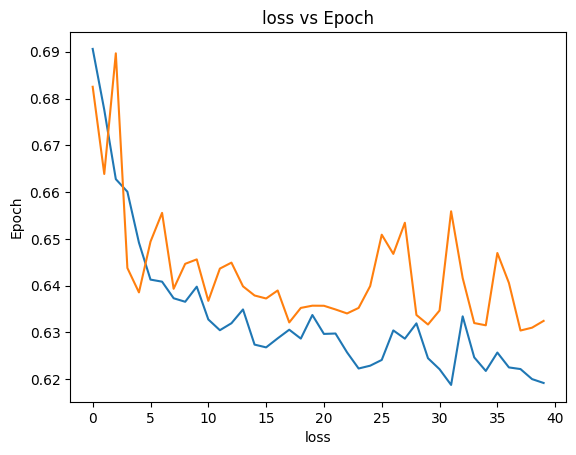

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('loss')
plt.ylabel('Epoch')
plt.title('loss vs Epoch')
plt.show()


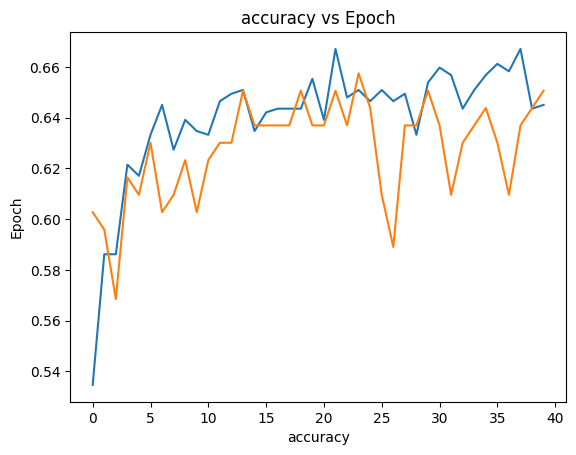

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('accuracy')
plt.ylabel('Epoch')
plt.title('accuracy vs Epoch')
plt.show()

In [15]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [16]:
#Loading the model
inception_resnet_model=InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
feature_extractor=Model(inputs=inception_resnet_model.input, outputs=inception_resnet_model.get_layer('conv_7b_ac').output)

for layers in feature_extractor.layers:
    layers.trainable=False

x=feature_extractor.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024, activation='relu')(x)

output=Dense(1, activation='sigmoid')(x)

model=Model(inputs=feature_extractor.input, outputs=output)


model_checkpoint = ModelCheckpoint('inception_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 55,911,649 (213.29 MB)

 Trainable params: 1,574,913 (6.01 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [17]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(x_train,y_train, epochs=30, validation_data=(x_val, y_val), verbose=1, callbacks=[model_checkpoint, reduce_lr])

Epoch 1/30
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5186 - loss: 1.7038

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('loss')
plt.ylabel('Epoch')
plt.title('loss vs Epoch')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('accuracy')
plt.ylabel('Epoch')
plt.title('accuracy vs Epoch')
plt.show()